In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map

import illustris_python as il

In [2]:
with np.load("halo_data.npz") as data:
    time = data["TNGtime"]
    redshift = data["TNGredshift"]

In [3]:
# load data
with np.load("history_data.npz") as data:
    halo_mass = data["Mh"]
    stellar_mass = data["Ms"]
    gas_mass = data["Mg"]

# calculate formation time for all galaxies (time to accrete half final DM mass)
form_time = np.ndarray(len(halo_mass))
half_mass = halo_mass[:,-1] - np.log10(2)

for i in range(len(half_mass)):
    j = 0
    while halo_mass[i,j] < half_mass[i] or np.isnan(halo_mass[i,j]):
        j += 1
    form_time[i] = time[j]
    
print(np.min(form_time), np.max(form_time))
# form_time = np.clip(form_time, 0, 10)

0.596 13.803


Let's split up the galaxies into 4 equally populated samples by formation time.

In [19]:
time_lower_bound = np.min(form_time)
time_upper_bound = np.max(form_time)

time_range = (form_time > time_lower_bound) * (form_time < time_upper_bound)

quartiles = np.flip(np.percentile(form_time[time_range], [25, 50, 75]))

first_quartile = (form_time > quartiles[0]) * (form_time < time_upper_bound)
second_quartile = (form_time > quartiles[1]) * (form_time < quartiles[0])
third_quartile = (form_time > quartiles[2]) * (form_time < quartiles[1])
fourth_quartile = (form_time > time_lower_bound) * (form_time < quartiles[2])

print(form_time[first_quartile].shape, form_time[second_quartile].shape, form_time[third_quartile].shape, form_time[fourth_quartile].shape)

quartile_filters = [first_quartile, second_quartile, third_quartile, fourth_quartile]
bounds = [time_upper_bound, *quartiles, time_lower_bound]

(12199,) (10042,) (11405,) (11324,)


In [25]:
inflection_points = [2.3, 3.5, 8.9]  # [Gyr]

Now let's plot the median mass histories over time for each quartile:

In [62]:
baryonic_mass = np.log10(10**stellar_mass + 10**gas_mass)
shm = 10**(stellar_mass - halo_mass)
bhm = 10**(baryonic_mass - halo_mass)

median_stellar_mass = np.ndarray((4, 100))
median_gas_mass = np.ndarray((4, 100))
median_halo_mass = np.ndarray((4, 100))
median_baryonic_mass = np.ndarray((4, 100))
median_shm = np.ndarray((4, 100))
median_bhm = np.ndarray((4, 100))

std_stellar_mass = np.ndarray((4, 100))
std_gas_mass = np.ndarray((4, 100))
std_halo_mass = np.ndarray((4, 100))
std_baryonic_mass = np.ndarray((4, 100))
std_shm = np.ndarray((4, 100))
std_bhm = np.ndarray((4, 100))


for i, quartile in enumerate(quartile_filters):
    for t in range(100):
        median_stellar_mass[i, t] = np.nanmedian(stellar_mass[quartile, t])
        median_gas_mass[i, t] = np.nanmedian(gas_mass[quartile, t])
        median_halo_mass[i, t] = np.nanmedian(halo_mass[quartile, t])
        median_baryonic_mass[i, t] = np.nanmedian(baryonic_mass[quartile, t])
        median_shm[i, t] = np.nanmedian(shm[quartile, t])
        median_bhm[i, t] = np.nanmedian(bhm[quartile, t])
        
        std_stellar_mass[i, t] = np.nanstd(stellar_mass[quartile, t])
        std_gas_mass[i, t] = np.nanstd(gas_mass[quartile, t])
        std_halo_mass[i, t] = np.nanstd(halo_mass[quartile, t])
        std_baryonic_mass[i, t] = np.nanstd(baryonic_mass[quartile, t])

std_shm = median_shm*np.sqrt((std_stellar_mass/median_stellar_mass)**2 + (std_halo_mass/median_halo_mass)**2)
std_bhm = median_bhm*np.sqrt((std_baryonic_mass/median_baryonic_mass)**2 + (std_halo_mass/median_halo_mass)**2)

Text(0.5, 0, 'Age of the Universe [Gyr]')

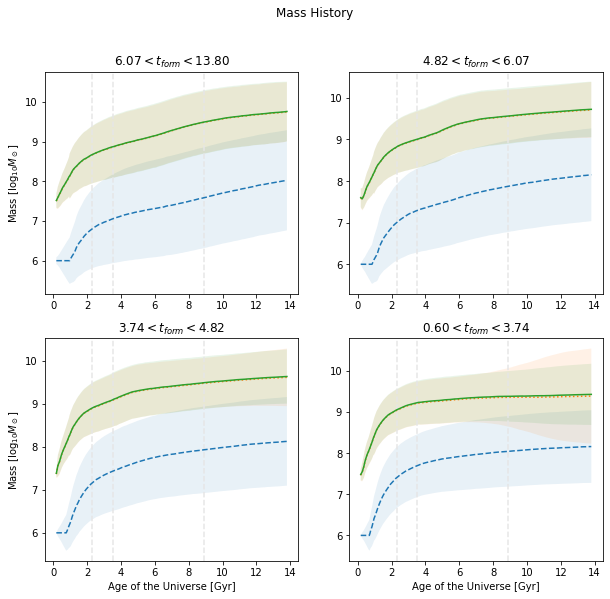

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points:
        axes[i].axvline(point, ls="--", c="0.9")
        
    axes[i].set_title(f"${bounds[i+1]:.2f}<t_{{form}}<{bounds[i]:.2f}$")
    axes[i].plot(time, median_stellar_mass[i], linestyle="--")
    axes[i].fill_between(time, median_stellar_mass[i] - std_stellar_mass[i], median_stellar_mass[i] + std_stellar_mass[i], alpha=0.1)
    axes[i].plot(time, median_gas_mass[i], linestyle=":")
    axes[i].fill_between(time, median_gas_mass[i] - std_gas_mass[i], median_gas_mass[i] + std_gas_mass[i], alpha=0.1)
    axes[i].plot(time, median_baryonic_mass[i], linestyle="-")
    axes[i].fill_between(time, median_baryonic_mass[i] - std_baryonic_mass[i], median_baryonic_mass[i] + std_baryonic_mass[i], alpha=0.1)

fig.suptitle("Mass History")
axes[0].set_ylabel("Mass [$\\log_{10}M_\\odot$]")
axes[2].set_ylabel("Mass [$\\log_{10}M_\\odot$]")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

# fig.savefig("mass_history")

Now we plot the median stellar mass/halo mass ratio for all time in the different quartiles, we should see a difference between young and old.

(0.0, 0.005)

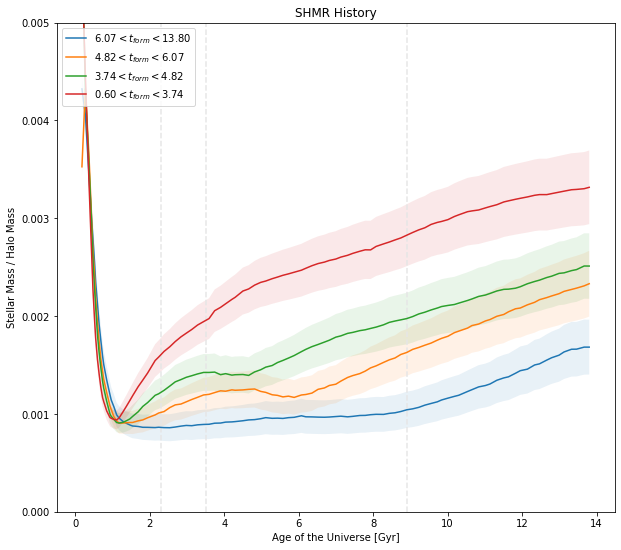

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

for point in inflection_points:
        ax.axvline(point, ls="--", c="0.9")

for i in range(4):
    ax.plot(time, median_shm[i], label=f"${bounds[i+1]:.2f}<t_{{form}}<{bounds[i]:.2f}$")
    ax.fill_between(time, median_shm[i] - std_shm[i], median_shm[i] + std_shm[i], alpha=0.1)

ax.set_title("SHMR History")
ax.set_ylabel("Stellar Mass / Halo Mass")
ax.set_xlabel("Age of the Universe [Gyr]")
ax.legend(loc="upper left")
ax.set_ylim(0, 0.005)

# fig.savefig("shmr_history")

Now we do the same thing but for baryonic mass/halo mass. We should not see a difference...

(0.0, 0.11)

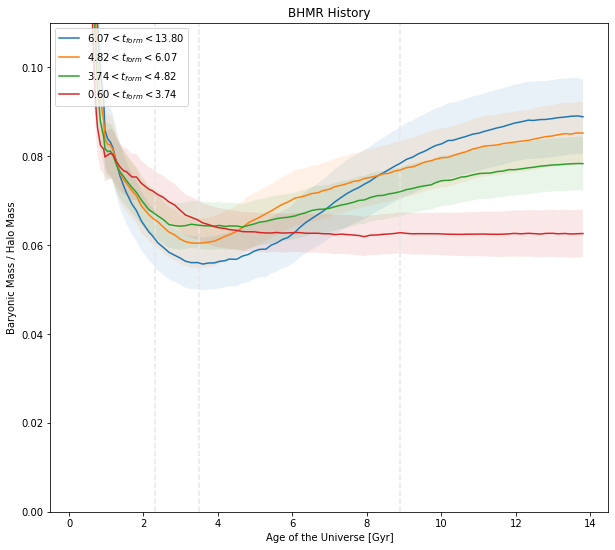

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

for point in inflection_points:
        ax.axvline(point, ls="--", c="0.9")

for i in range(4):
    ax.plot(time, median_bhm[i], label=f"${bounds[i+1]:.2f}<t_{{form}}<{bounds[i]:.2f}$")
    ax.fill_between(time, median_bhm[i] - std_bhm[i], median_bhm[i] + std_bhm[i], alpha=0.1)

ax.set_title("BHMR History")
ax.set_ylabel("Baryonic Mass / Halo Mass")
ax.set_xlabel("Age of the Universe [Gyr]")
ax.legend(loc="upper left")
ax.set_ylim(0, 0.11)

# fig.savefig("bhmr_history")